In [10]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression



In [50]:
out = loadmat('training-data.mat')
XdataOut = out['u'].T
YdataOut = out['th'].T

size = XdataOut.size
subset_size = 80000
random_select = np.random.choice(size, size=subset_size, replace=False) #randomly selects 100 no. of data points without replacement

Xdata = XdataOut[random_select]  # Selected data points stored in Xdata
Ydata = YdataOut[random_select]  # Selected data points stored in Ydata
#print(type(Xdata))
#print(Xdata.shape)

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) # Split data in training and validation sets
print(Xtrain.shape)
print(Xval.shape)

(60000, 1)
(20000, 1)


In [51]:


def f(upast, ypast):# mathematical relationship between past input and output values (upast and ypast) to compute the current output value (ystar). 
    ukm = upast[-nb:]  # Take the last nb elements of upast
    ykm = ypast[-na:]  # Take the last na elements of ypast
    ystar = (0.8 - 0.5 * np.exp(-ykm[-1] ** 2)) * ykm[-1] - (0.3 + 0.9 * np.exp(-ykm[-1] ** 2)) * ykm[-2] \
            + ukm[-1] + 0.2 * ukm[-2] + 0.1 * ukm[-1] * ukm[-2]
    return ystar + np.random.normal(scale=0.01)



def use_NARX_model_in_simulation(ulist, f, na, nb): # list of input values (ulist), function (f), order of autoregressive (na) and exogenous inputs (nb)
    # initialize upast and ypast as lists (arrays of zeros with correct size).
    upast = np.zeros(nb) 
    ypast = np.zeros(na)

    ylist = []
    for unow in ulist:
        # compute the current output value y given by f
        ynow = f(upast, ypast)

        # update past arrays
        upast = np.roll(upast, -1)
        upast[-1] = unow[-1]  # Take the last element of unow
        ypast = np.roll(ypast, -1)
        ypast[-1] = ynow

        # save result
        ylist.append(ynow)
    return np.array(ylist)



na, nb = 2, 2 #autoregressive (na) & exogenous (nb)


np.random.seed(42)

def make_training_data(ulist,ylist,na,nb): #create the training data by combining the past input and output values.
    #Xdata = (Nsamples,Nfeatures)
    #Ydata = (Nsamples)
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)): #skip the initial indices that don't have enough past input and output values to form a complete feature vector.
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]]))  # constructs a feature vector Xdata by concatenating the past nb input values and past na output values. 
        Ydata.append(ylist[k]) # corresponding current output value ylist[k] is appended to the target values list Ydata.
    return np.array(Xdata), np.array(Ydata)


#################################################################################################################
# Section 3: Data Splitting
# Split the data into training and validation sets
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata, test_size=0.25, random_state=42, shuffle=True)
##################################################################################################################

Xtrain = np.squeeze(Xtrain)
Xval = np.squeeze(Xval)
Ytrain = np.squeeze(Ytrain)
Yval = np.squeeze(Yval)

size_train = Xtrain.shape[0]
size_val = Xval.shape[0]
subset_size_train = 300
subset_size_val = 75
random_select_train = np.random.choice(size_train, size=subset_size_train, replace=False)
random_select_val = np.random.choice(size_val, size=subset_size_val, replace=False)

Xtrain = Xtrain[random_select_train]
Xval = Xval[random_select_val]
Ytrain = Ytrain[random_select_train]
Yval = Yval[random_select_val]
print('Xtrain.shape',Xtrain.shape)
print('Xval.shape',Xval.shape)
print('Ytrain.shape',Ytrain.shape)
print ('Yval.shape', Yval.shape)


Xtrain.shape (300,)
Xval.shape (75,)
Ytrain.shape (300,)
Yval.shape (75,)


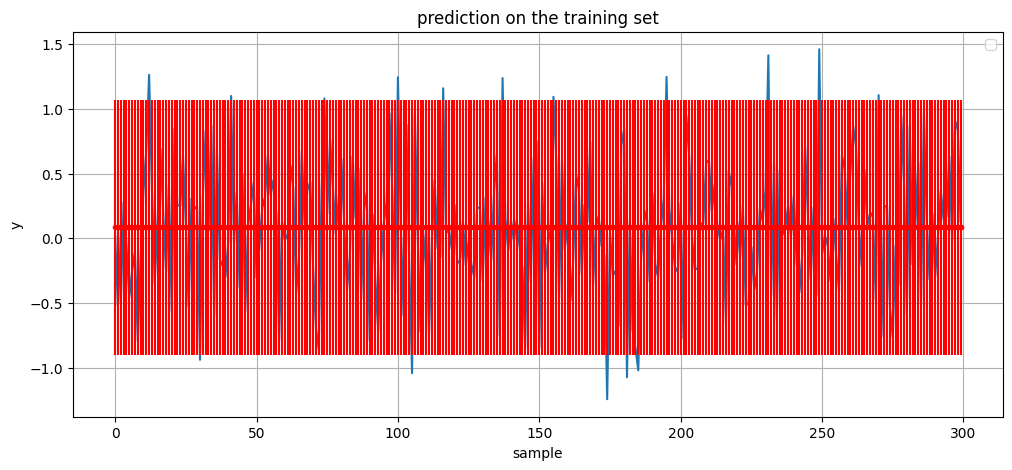

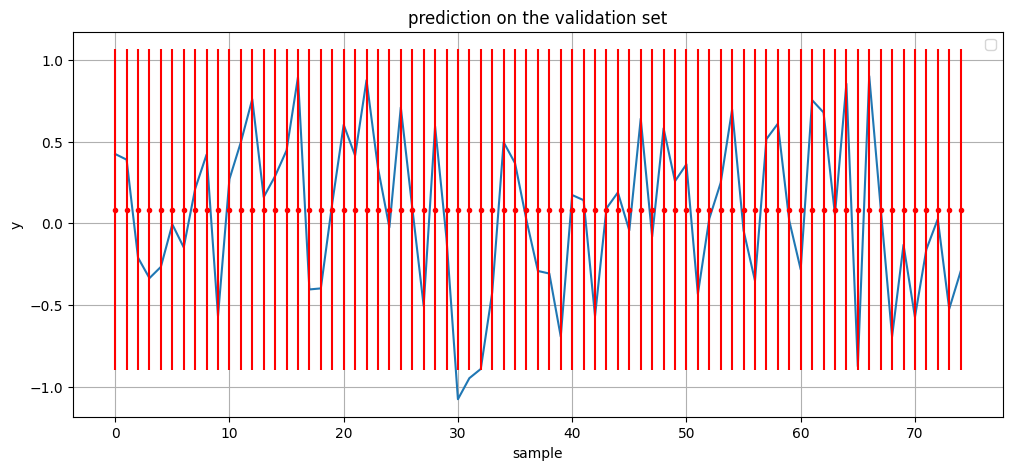

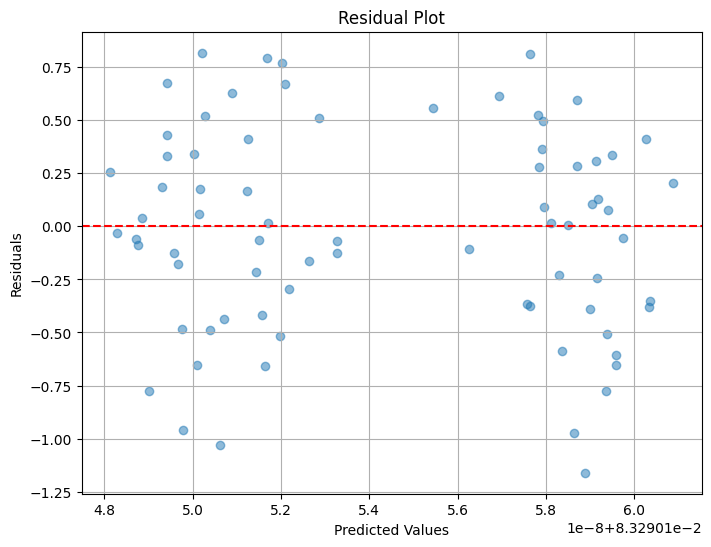

Validation NRMS= 1.000980412446315


In [60]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error


##############################################################################################
# Section 4: Fitting and Residual Calculations

kernel = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

# Reshape the training data
Xtrain_reshaped = Xtrain.reshape(-1, 1)
Ytrain_reshaped = Ytrain.reshape(-1, 1)

reg.fit(Xtrain_reshaped, Ytrain_reshaped)

Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain_reshaped, return_std=True)




# Residual calculations and plotting
# RESIDUAL plots of training set 
plt.figure(figsize=(12,5)) #a)
plt.title('prediction on the training set')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','predicted'])
plt.plot(Ytrain) # plots the measured values of the training set
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') #plots the predicted values with error/uncertinty 
plt.show() #a)


# Residual plots of validation set 
plt.figure(figsize=(12,5)) #a)
plt.title('prediction on the validation set')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','predicted'])
plt.plot(Yval) #a)
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') #a)
plt.show() #a)


# Residual Plot
residuals = Yval - Yval_pred # Calculate residuals
plt.figure(figsize=(8, 6))
plt.scatter(Yval_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


print(f'Validation NRMS= {np.mean((Yval_pred - Yval) ** 2) ** 0.5 / np.std(Yval)}')
###################################################################################################


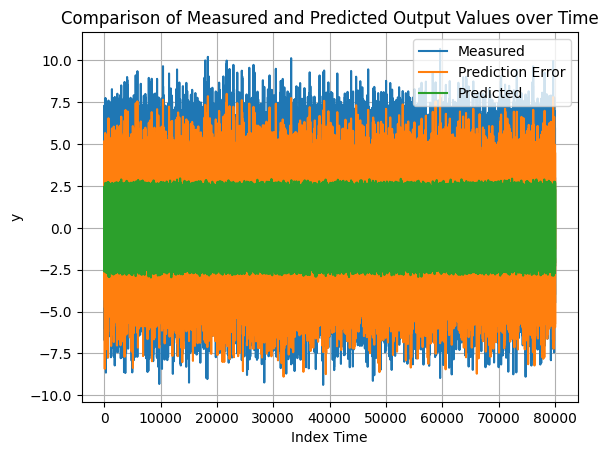

Test NRMS: 0.7577950437846471


In [53]:
def use_NARX_model_in_simulation(ulist, f, na, nb):
    upast = np.zeros(na)
    ypast = np.zeros(nb)

    ylist = []
    for unow in ulist:
        # compute the current output value y given by f
        ynow = f(upast, ypast)
        ylist.append(ynow)  # Append the scalar value directly
        # update past arrays
        upast = np.roll(upast, -1)
        ypast = np.roll(ypast, -1)
        upast[-1] = unow
        if isinstance(ynow, np.ndarray):
            ypast[-1] = ynow[0]  # Extract the scalar value
        else:
            ypast[-1] = ynow

    return np.array(ylist)

ytest = use_NARX_model_in_simulation(Xdata, f, na, nb)

model_now = reg
fmodel = lambda u, y: np.concatenate([u.reshape(-1, 1), model_now.predict(u.reshape(-1, 1))[:, None]], axis=1)[0]

ytest_pred = use_NARX_model_in_simulation(Xdata, fmodel, na, nb)


plt.plot(ytest)
plt.plot(ytest - ytest_pred[:, 0])  # Subtract the prediction's first column (scalar value)
plt.plot(ytest_pred[:, 0])  # Plot the prediction's first column (scalar value)
plt.grid()
plt.title('Comparison of Measured and Predicted Output Values over Time')
plt.xlabel('Index Time')
plt.ylabel('y')
plt.legend(['Measured', 'Prediction Error', 'Predicted'])
plt.show()

test_nrms = np.mean((ytest - ytest_pred[:, 0]) ** 2) ** 0.5 / np.std(ytest)
print('Test NRMS:', test_nrms)
